In [13]:
import sys
import os
import itertools

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import scipy.optimize as spopt
import scipy.integrate as spi
import scipy.stats as sps

import tensorflow as tf
import pandas as pd

sys.path.append("../../ndsvae/")
import ndsvae as ndsv

sys.path.append("../")
import util
import plotutils as pu

%matplotlib inline

In [2]:
config = "ns_3_mreg_3_msub_0_nf_32"
conn = "linw"
preproc = "dicer"
modelname = "AB"

ds = ndsv.Dataset.from_file(f"../run/hcp/hcp100_{conn}_{preproc}/dataset.npz")
run = util.select_run_fc(f"hcp100_{conn}_{preproc}", modelname, config, [0,1], "hcp")
direc = f"../run/hcp/hcp100_{conn}_{preproc}/model{modelname}/{config}/run{run:02d}"
params = util.load_params(os.path.join(direc, "parameters"), np.r_[:100])

model = util.get_model(modelname, config, ds)
model.load_weights(f"../run/hcp/hcp100_{conn}_{preproc}/model{modelname}/{config}/run{run:02d}/fit/model")

2022-08-10 13:26:13.386144: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-10 13:26:13.387956: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [3]:
nsub, nreg, _, nt = ds.y.shape
ntd = int(nt//3)
HALF_WINDOW = 41

In [4]:
def calc_dfc(y, half_window):
    nreg, nt = y.shape
    fc = np.zeros((nt, nreg, nreg))

    for i in range(half_window, nt-half_window):
        fc[i] = np.corrcoef(y[:,i-half_window:i+half_window])

    inds = np.triu_indices(nreg, k=1)
    fc = fc[:, inds[0], inds[1]][half_window:-half_window]
    dfc = np.corrcoef(fc)

    return dfc

def plot_dfc(ax, dfc, colorbar=False):
    plt.sca(ax)    
    
    plt.imshow(dfc, vmin=0, vmax=1, cmap='magma', interpolation='none', 
               extent=[0,dfc.shape[0]*DT,dfc.shape[0]*DT,0])
    plt.xticks([0, 400, 800])
    plt.yticks([0, 400, 800])    
    plt.xlabel("Time [s]")
    plt.ylabel("Time [s]")
    
    if colorbar:
        plt.colorbar(aspect=10)
        
def simulate_dfc(seed, nsamples, subjects, return_dfc=False):    
    nsub = len(subjects)    
    ks = np.zeros((nsub, nsamples))   
    dfcs = []    

    for i, isub in enumerate(subjects):
        print(isub, end=' ', flush=True)
        dfc_emp = calc_dfc(ds.y[isub,:,0,:], HALF_WINDOW)
        triu = np.triu_indices(dfc_emp.shape[0], k=1)
       
        dfcs.append([])

        np.random.seed(seed)
        sims = model.simulate_subjects(ds.w[[isub]], nt+ntd, thetareg=params.thetareg[[isub]], thetasub=None,
                                       us=None, n=nsamples)
        y = sims.y.numpy()[:,0,:,0,-nt:]

        for isim in range(nsamples):
            dfc = calc_dfc(y[isim], HALF_WINDOW)
            ks[i,isim] = sps.kstest(dfc_emp[triu], dfc[triu])[0]
            
            if return_dfc:
                dfcs[-1].append(dfc)
            
    if return_dfc:
        dfcs = np.array(dfcs)
        return ks, dfcs
    else:
        return ks

In [5]:
ks = simulate_dfc(seed=0, nsamples=20, subjects=np.r_[:nsub])

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [6]:
isubs = [3, 10, 18]
_, dfcs = simulate_dfc(seed=0, nsamples=1, subjects=isubs, return_dfc=True)

3 10 18 

## Matplotlib config

In [9]:
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = "Arial"

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Figure

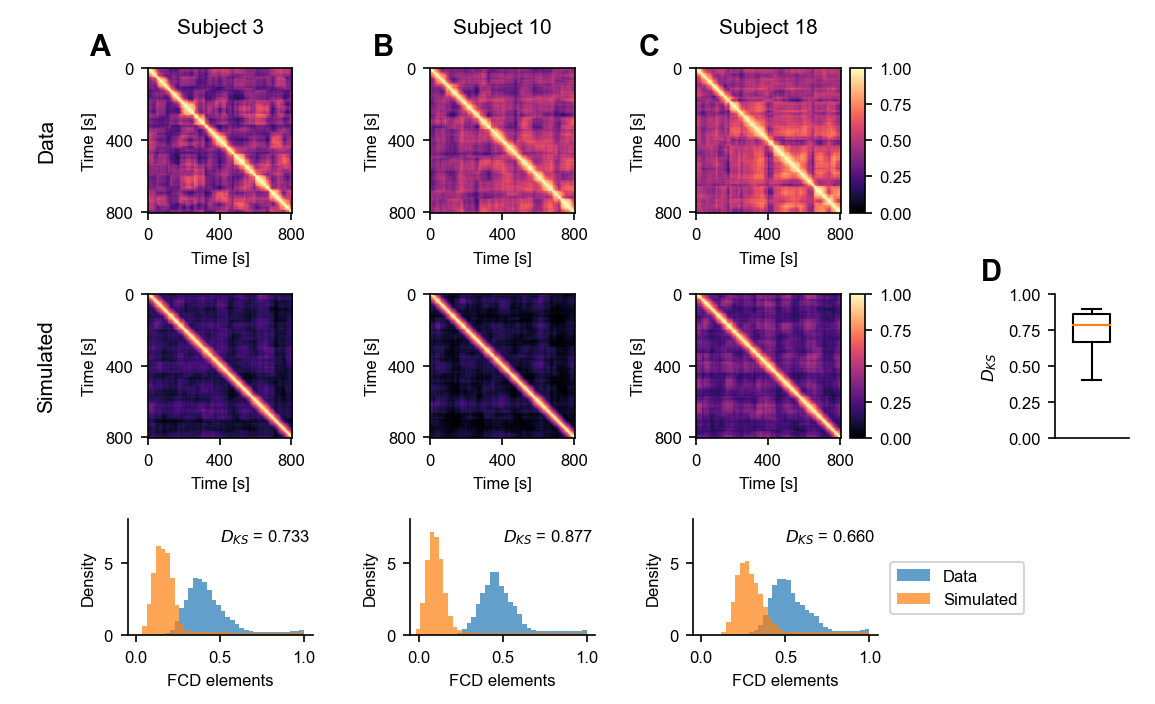

In [63]:
DT = 0.72
isample = 0

fig = plt.figure(figsize=(7.5, 4.5), dpi=150)
axes = []

gs = GridSpec(nrows=3, ncols=5, wspace=0.8, hspace=0.6, width_ratios=[1,1,1,-0.1,0.4], height_ratios=[1,1,0.8],
              left=0.1, right=0.99, top=0.92, bottom=0.08
             )

for i, isub in enumerate(isubs):
    # Empirical FCD
    ax = plt.subplot(gs[0,i])
    dfc_emp = calc_dfc(ds.y[isub,:,0,:], HALF_WINDOW)    
    plot_dfc(ax, dfc_emp, colorbar=(i==2))
    plt.title(f"Subject {isub}\n", fontsize=10)
    if i == 0:
        plt.text(-0.7, 0.5, "Data", ha='center', va='center', rotation='vertical', fontsize=10,
                 transform=ax.transAxes)
    axes.append(ax)
    
    # Simulated FCD
    ax = plt.subplot(gs[1,i])
    dfc_sim = dfcs[i,isample]
    plot_dfc(ax, dfc_sim, colorbar=(i==2))
    if i == 0:
        plt.text(-0.7, 0.5, "Simulated", ha='center', va='center', rotation='vertical', fontsize=10,
                 transform=ax.transAxes)
    
    # KS distributions
    triu = np.triu_indices(dfc_emp.shape[0], k=1)
    ax = plt.subplot(gs[2,i])
    plt.hist(dfc_emp[triu], bins=np.linspace(-0.1, 1, 41), density=True, alpha=0.7, label="Data")
    plt.hist(dfc_sim[triu], bins=np.linspace(-0.1, 1, 41), density=True, alpha=0.7, label="Simulated")
    plt.xlabel("FCD elements")
    plt.ylabel("Density")
    plt.text(0.5, 0.85, f"$D_{{KS}}$ = {ks[isub,isample]:.3f}", ha='left', va='center',
             transform=plt.gca().transAxes, fontsize=8)
    plt.xlim(-0.05, 1.05)
    plt.ylim(0,8)
    
    if i == 2:
        # plt.legend(loc='upper left')
        plt.legend(bbox_to_anchor=(1.02, 0.7))
        
    pu.bottomleft_spines(ax)
        

# Summary distribution
ax = plt.subplot(gs[1,4])
plt.boxplot(ks[:20].ravel(), showfliers=False)
plt.xlim(0.85, 1.15)
plt.ylim(0, 1)
plt.ylabel("$D_{KS}$")
plt.xticks([])
pu.bottomleft_spines(ax)
axes.append(ax)

pu.add_panel_labels(fig=fig, axes=axes, fontsize=14, xs=[-0.4, -0.4, -0.4, -1.0])


bg = pu.Background(visible=False)

plt.savefig("img/Fig_HCP_FCD.pdf")

In [11]:
! ls ..

activate.sh	       etc		     notebooks	   Snakefile
balloon_windkessel.py  generate_datasets.py  plot.py	   statdist.py
data		       hcp100.smk	     plotutils.py  subjects.txt
data-8sub	       logs		     __pycache__   util.py
env.yml		       modify_dataset.py     run
